In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import normalize

def conv_circ(signal, kernal, n=None):
    '''
    Parameters
    ----------
    
    signal: array of length D
    
    ker: array of length D   

    Returns
    -------
    
    array of length D
    
    '''
    if n == None:
        n = len(signal) + len(kernal) - 1
        
    return np.real(np.fft.ifft(np.fft.fft(signal, n)*np.fft.fft(kernal, n) ))

def plate_formula(n, k, err):
    '''
    Determine the number of dimensions needed according to Plate's (2003)
    formula:
      D = 3.16(K-0.25)ln(N/err^3)
    where D is the number of dimensions, K is the maximum number of terms
    to be combined, N is the number of atomic values in the langauge, and
    err is the probability of error.
    
    USAGE: D = plate_formula(n, k, err)
    '''
    return int(round(3.16 * (k-0.25) * (np.log(n) - 3 * np.log(err))))


def embed(n, d, distr='spikeslab_gaussian', param=None):
    # Embed symbols in a vector space.
    #
    # USAGE: X = embed(n, d, distr='spikeslab_gaussian', param=None)
    #
    # INPUTS:
    #   n - number of symbols
    #   d - number of dimensions
    #   distr - string specifying the distribution on the vector space:
    #           'spikeslab_gaussian' - mixture of Gaussian "slab" and Bernoulli "spike"
    #           'spikeslab_uniform' - mixture of uniform "slab" and Bernoulli "spike"
    #
    #   param (optional) - parameters of the distribution:
    #                      'spikeslab_gaussian' - param = [variance, spike probability] (default: [1 1])
    #                      'spikeslab_uniform' - param = [bound around 0, spike probability] (default: [1 1])
    # OUTPUTS;
    #   X - [N x D] matrix
    #
    # Sam Gershman, Jan 2013
    
    if param is None:
        param = [1, 1]
    spike = np.round(np.random.rand(n, d) < param[1])
    
    if distr == 'spikeslab_gaussian':
        slab = np.random.randn(n, d) * param[1]
    elif distr == 'spikeslab_uniform':
        slab = np.random.uniform(-param[1], param[1], (n, d))
    else:
        raise(Exception)
    
    return normalize(spike * slab)
        
            
        
def encode(a, b):
    return normalize(conv_circ(a, b, np.size(a)))

def decode(a, b):
    c = np.real(np.fft.ifft(np.fft.fft(a, np.size(a)) * np.conj(np.fft.fft(b, np.size(a))) ) )
    return c

/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


[[ 1.          0.49569371]
 [ 0.49569371  1.        ]]


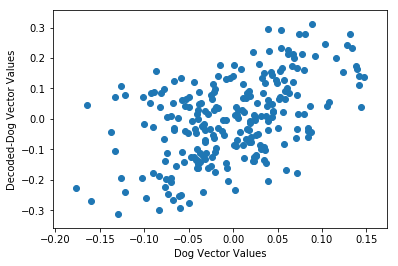

In [2]:
# figure out how many dimensions we need
n = 10;     # vocabulary size
k = 5;      # maximum number of terms to be combined
err = 0.01; # error probability
d = plate_formula(n, k, err);

# embedding parameters
distr = 'spikeslab_gaussian'
param = [1.0, 1.0]

dog = embed(1, d, distr, param)
agent = embed(1, d, distr, param)
chase = embed(1, d, distr, param)
verb = embed(1, d, distr, param)
cat = embed(1, d, distr, param)
patient = embed(1, d, distr, param)

sentance = encode(dog, agent) + encode(chase, verb)# + encode(cat, patient)
dog_decoded = decode(sentance, agent)

plt.scatter(dog, dog_decoded)
print np.corrcoef(dog, dog_decoded)
plt.gca().set_xlabel('Dog Vector Values')
plt.gca().set_ylabel('Decoded-Dog Vector Values')
plt.show()

# Compositonality
Circular convolution preserves the simliarity structure of the underlying vectors. That is, if two vectors are more are similar to each other in vector space, then their convolutions with a third vector will retain that similarity.  We can show this buy approximating a circular convolution with a tensor product (Plate, 1995; Doumas and Hummel, 2005). 

Formally, this stems from the observation is that if $\mathbf{a}$, $\mathbf{b}$, and $\mathbf{c}$  are $D$-dimensional random vectors drawn from $\mathcal{N}(0, \sigma \text{I})$ then typically

$$\cos(\theta_{\mathbf{a} + \mathbf{c}, \mathbf{b} + \mathbf{c}}) > \cos(\theta_{\mathbf{a}, \mathbf{b}})$$

or

$$\frac{(\mathbf{a} + \mathbf{c})^{\text{T}}(\mathbf{b} + \mathbf{c})}{||(\mathbf{a} + \mathbf{c})^{\text{T}}(\mathbf{b} + \mathbf{c}) ||} > \frac{\mathbf{a}^{\text{T}}\mathbf{b}}{||\mathbf{a}^{\text{T}}\mathbf{b}||}$$

meaning that the random vectors that share a common (linearly additive) factor are more to each other than the would be if you were to subtract thier common factor.

We can see that this generally the case by noting that $(\mathbf{a} + \mathbf{c})^{\text{T}}(\mathbf{b} + \mathbf{c}) = \mathbf{a}^{\text{T}}\mathbf{b} + (\mathbf{a} + \mathbf{b})^\text{T}\mathbf{c} + \mathbf{c}^\text{T}\mathbf{c}$, hense we can re-arange our claim to that typically $\mathbf{c}^\text{T}\mathbf{c} > (\mathbf{a} + \mathbf{b})^\text{T}\mathbf{c}$, which is true as long as $\mathbf{c}$ is not strongly anti-correlated to $\textbf{a}$ and $\textbf{b}$. Asymptoically, this will be the case as 

$$\mathbb{E}[(\mathbf{a}+\mathbf{b})^\text{T}\mathbf{c}] =\sum_{i=1}^{D}\mathbb{E}[a_i]\mathbb{E}[c_i]+\sum_{i=1}^{D}\mathbb{E}[b_i]\mathbb{E}[c_i] + (r_{ac} + r_{bc})\sigma^2 = 0$$

where $r_{ac}$ and $r_{ac}$ are the correlations between vectors $\mathbf{a}$ and $\mathbf{c}$ and vectors $\mathbf{b}$ and $\mathbf{c}$, respectively, and is zero for both when $\mathbf{a}$, $\mathbf{b}$, $\mathbf{c}\sim\mathcal{N}(0, \sigma\text{I})$. Thus, we would expect the presense of a common factor to increase the simliarity of two random vectors.


We can be more rigorus with this proof but it's easiest to just to show it is the case empirically, that as we increase the dimensionality of the vecotrs $D$, $\Pr\left (\cos(\theta_{\mathbf{a} + \mathbf{c}, \mathbf{b} + \mathbf{c}}) > \cos(\theta_{\mathbf{a}, \mathbf{b}})\right )$ approches 1:



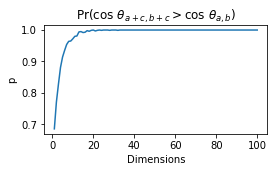

In [3]:
N = 1000
dot = [None]* 100
for d in range(1, 101):
    a = (np.random.randn(N, d))
    b = (np.random.randn(N, d))
    c = (np.random.randn(N, d))
    f = np.array([np.dot(a[ii, :] + c[ii, :], b[ii, :] + c[ii, :]) - np.dot(a[ii, :], b[ii, :])
        for ii in range(N)]) 
    dot[d-1] = np.mean(f >= 0)

plt.figure(figsize=(4, 2))    
plt.plot(range(1, 101), dot)
plt.xlabel('Dimensions')
plt.ylabel('p')
plt.title(r'$\Pr\left ( \cos\ \theta_{a+c, b+c} > \cos\ \theta_{a, b} \right )$')

We can extend this arguements to tensor products by first noting that tensor products are distributive, so:

$$(\mathbf{x} + \mathbf{y}) \otimes\mathbf{z} = \mathbf{x}\otimes\mathbf{z} + \mathbf{y}\otimes\mathbf{z}$$

Thus, if we make two random vectors $\mathbf{a}$ and $\mathbf{b}$ similar to eachother by adding to each a common factor $\mathbf{d}$, then taking the tensor product of each of those two vectors with a third random vector $\mathbf{c}$, we can decompose both tensor products into the sum of two seperate tensors:

$$(\mathbf{a} + \mathbf{d}) \otimes\mathbf{c} = \mathbf{a}\otimes\mathbf{c} + \mathbf{d}\otimes\mathbf{c}$$
$$(\mathbf{b} + \mathbf{d}) \otimes\mathbf{c} = \mathbf{b}\otimes\mathbf{c} + \mathbf{d}\otimes\mathbf{c}$$

Thus, both tensors share a common tensor. Then, by the arguments above we can show that:

$$\cos \theta_{(\mathbf{a} + \mathbf{d}) \otimes\mathbf{c}, (\mathbf{b} + \mathbf{d}) \otimes\mathbf{c}} > \cos \theta_{\mathbf{a} \otimes\mathbf{c}, \mathbf{b}\otimes\mathbf{c} }$$

will be true with probabilty approaching 1 as the dimensionality of the vectors goes to infinity. Thus, taking the tensor product of two similar vectors and a third random vector will result in two similar tensor products. Because circular convolution resembles a tensor product opperation (Plate, 1995; Doumas and Hummel, 2005) this argumemt will hold for it as well. Without getting into a rigorous proof of this, we can demonstrate this empirically:


In [4]:
from sklearn.preprocessing import normalize

# both Olivia and William will share the property isPerson
isPerson = embed(1, d, distr, param)


Olivia = normalize(embed(1, d, distr, param) + isPerson)
William = normalize(embed(1, d, distr, param) + isPerson)
Agent = embed(1, d, distr, param)
Coffee = embed(1, d, distr, param)


OliviaAgent = encode(Olivia, Agent)
WilliamAgent = encode(William, Agent)
CoffeeAgent = encode(Coffee, Agent)

print "Dot Product:"
print 
print "dot(Olivia, William) = %.3f" % np.dot(OliviaAgent, WilliamAgent.T)[0][0]
print "dot(Olivia, Coffee)  = %.3f" % np.dot(CoffeeAgent, WilliamAgent.T)[0][0]
print "dot(Coffee, William) = %.3f" % np.dot(OliviaAgent, CoffeeAgent.T)[0][0]


print 
print "dot(Olivia(*)Agent, William(*)Agent) = %.3f" % np.dot(Olivia, William.T)[0][0]
print "dot(Olivia(*)Agent, Coffee(*)Agent)  = %.3f" % np.dot(Coffee, William.T)[0][0]
print "dot(Coffee(*)Agent, William(*)Agent) = %.3f" % np.dot(Olivia, Coffee.T)[0][0]


print
print "Euclidean Distance:"
print 
print "||Olivia - William|| = %.3f" % np.linalg.norm(Olivia - William)
print "||Olivia - Coffee || = %.3f" % np.linalg.norm(Olivia - Coffee)
print "||Coffee - William|| = %.3f" % np.linalg.norm(Coffee - William)

print
print "||Olivia(*)Agent - William(*)Agent|| = %.3f" % np.linalg.norm(OliviaAgent - WilliamAgent)
print "||Olivia(*)Agent - Coffee(*)Agent || = %.3f" % np.linalg.norm(CoffeeAgent - WilliamAgent)
print "||Coffee(*)Agent - William(*)Agent|| = %.3f" % np.linalg.norm(OliviaAgent - CoffeeAgent)



Dot Product:

dot(Olivia, William) = 0.534
dot(Olivia, Coffee)  = 0.091
dot(Coffee, William) = -0.035

dot(Olivia(*)Agent, William(*)Agent) = 0.446
dot(Olivia(*)Agent, Coffee(*)Agent)  = 0.173
dot(Coffee(*)Agent, William(*)Agent) = 0.107

Euclidean Distance:

||Olivia - William|| = 1.053
||Olivia - Coffee || = 1.337
||Coffee - William|| = 1.286

||Olivia(*)Agent - William(*)Agent|| = 0.965
||Olivia(*)Agent - Coffee(*)Agent || = 1.348
||Coffee(*)Agent - William(*)Agent|| = 1.439
